In [17]:
#data['CombinedDate'] = data.to_datetime(df[['YEAR', 'MONTH', 'DAY']], format='%Y %m %d')
#print(df['date'])

##K-Means Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

ALLSKY_KT = Kejernihan Langit
T2M = Temperatur
TS =
PRECTOTCORR = Curah Hujan
PS = Rata - Rata Tekanan Permukaan Bumi
WS10M = Kecepatan angin rata2 10 m

In [2]:
data = pd.read_csv('D:/MODELING_ML/GIT/upwelling-pred-maninjau/data/Date_Formatted_Data.csv')
data

,CombinedDate,TS,PRECTOTCORR,WS10M
0,1/1/2020,27.64,1.92,1.50
1,2/1/2020,27.86,0.32,1.33
2,3/1/2020,27.85,1.87,0.97
3,4/1/2020,27.93,2.68,1.19
4,5/1/2020,27.81,8.82,1.53
...,...,...,...,...
1090,26/12/2022,27.01,3.98,1.62
1091,27/12/2022,26.79,9.20,1.82
1092,28/12/2022,26.13,41.57,2.42
1093,29/12/2022,25.80,12.00,1.53


In [3]:
data.head()

,CombinedDate,TS,PRECTOTCORR,WS10M
0,1/1/2020,27.64,1.92,1.50
1,2/1/2020,27.86,0.32,1.33
2,3/1/2020,27.85,1.87,0.97
3,4/1/2020,27.93,2.68,1.19
4,5/1/2020,27.81,8.82,1.53


In [4]:
data.shape

(1095, 4)

In [5]:
data.dtypes

CombinedDate     object
TS              float64
PRECTOTCORR     float64
WS10M           float64
dtype: object

In [12]:
# Identify rows with missing values in 'CombinedDate' after conversion
invalid_dates = data[data['CombinedDate'].isnull()]

# Display the rows with invalid dates for inspection
print(invalid_dates)


     CombinedDate     TS  PRECTOTCORR  WS10M
12            NaT  27.73         2.99   1.80
13            NaT  27.59         7.69   1.59
14            NaT  27.75         5.61   1.52
15            NaT  27.64        13.25   1.29
16            NaT  27.40        13.57   1.82
...           ...    ...          ...    ...
1090          NaT  27.01         3.98   1.62
1091          NaT  26.79         9.20   1.82
1092          NaT  26.13        41.57   2.42
1093          NaT  25.80        12.00   1.53
1094          NaT  26.00        23.47   3.31

[663 rows x 4 columns]


In [6]:
data

,CombinedDate,TS,PRECTOTCORR,WS10M
0,1/1/2020,27.64,1.92,1.50
1,2/1/2020,27.86,0.32,1.33
2,3/1/2020,27.85,1.87,0.97
3,4/1/2020,27.93,2.68,1.19
4,5/1/2020,27.81,8.82,1.53
...,...,...,...,...
1090,26/12/2022,27.01,3.98,1.62
1091,27/12/2022,26.79,9.20,1.82
1092,28/12/2022,26.13,41.57,2.42
1093,29/12/2022,25.80,12.00,1.53


In [7]:
# Drop rows with missing values in 'CombinedDate'
data_cleaned = data.dropna(subset=['CombinedDate']).reset_index(drop=True)

In [8]:
data['CombinedDate'] = pd.to_datetime(data['CombinedDate'], errors='coerce')
data.isnull().sum()

CombinedDate    663
TS                0
PRECTOTCORR       0
WS10M             0
dtype: int64

#### Mengatasi Outlier

In [11]:
data

,CombinedDate,TS,PRECTOTCORR,WS10M
0,2020-01-01,27.64,1.92,1.50
1,2020-02-01,27.86,0.32,1.33
2,2020-03-01,27.85,1.87,0.97
3,2020-04-01,27.93,2.68,1.19
4,2020-05-01,27.81,8.82,1.53
...,...,...,...,...
427,2022-08-12,26.26,17.21,2.16
428,2022-09-12,26.16,14.47,3.63
429,2022-10-12,26.00,21.81,2.90
430,2022-11-12,26.09,44.73,4.34


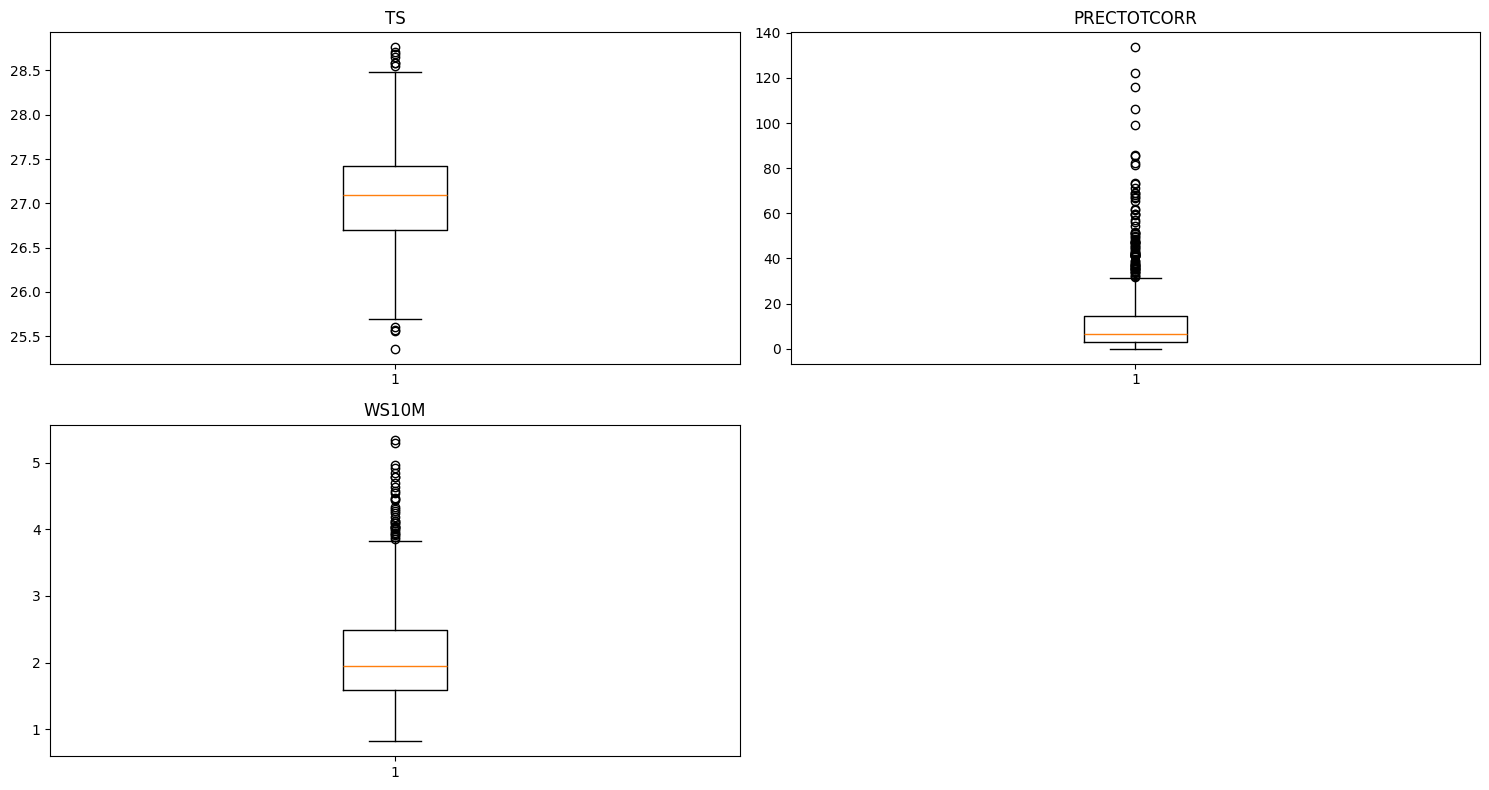

In [9]:
numerical_col = ["TS", "PRECTOTCORR", "WS10M"]
num_variables = len(numerical_col)
num_rows = 2  # We'll create 2 rows of subplots
num_cols = (num_variables + num_rows - 1) // num_rows  # Calculate number of columns needed

plt.figure(figsize=(15, 8))

for i, variable in enumerate(numerical_col):
    plt.subplot(num_rows, num_cols, i+1)
    plt.boxplot(data[variable], whis=1.5)
    plt.title(variable)

plt.tight_layout()
plt.show()

In [10]:
data

,CombinedDate,TS,PRECTOTCORR,WS10M
0,2020-01-01,27.64,1.92,1.50
1,2020-02-01,27.86,0.32,1.33
2,2020-03-01,27.85,1.87,0.97
3,2020-04-01,27.93,2.68,1.19
4,2020-05-01,27.81,8.82,1.53
...,...,...,...,...
1090,NaT,27.01,3.98,1.62
1091,NaT,26.79,9.20,1.82
1092,NaT,26.13,41.57,2.42
1093,NaT,25.80,12.00,1.53


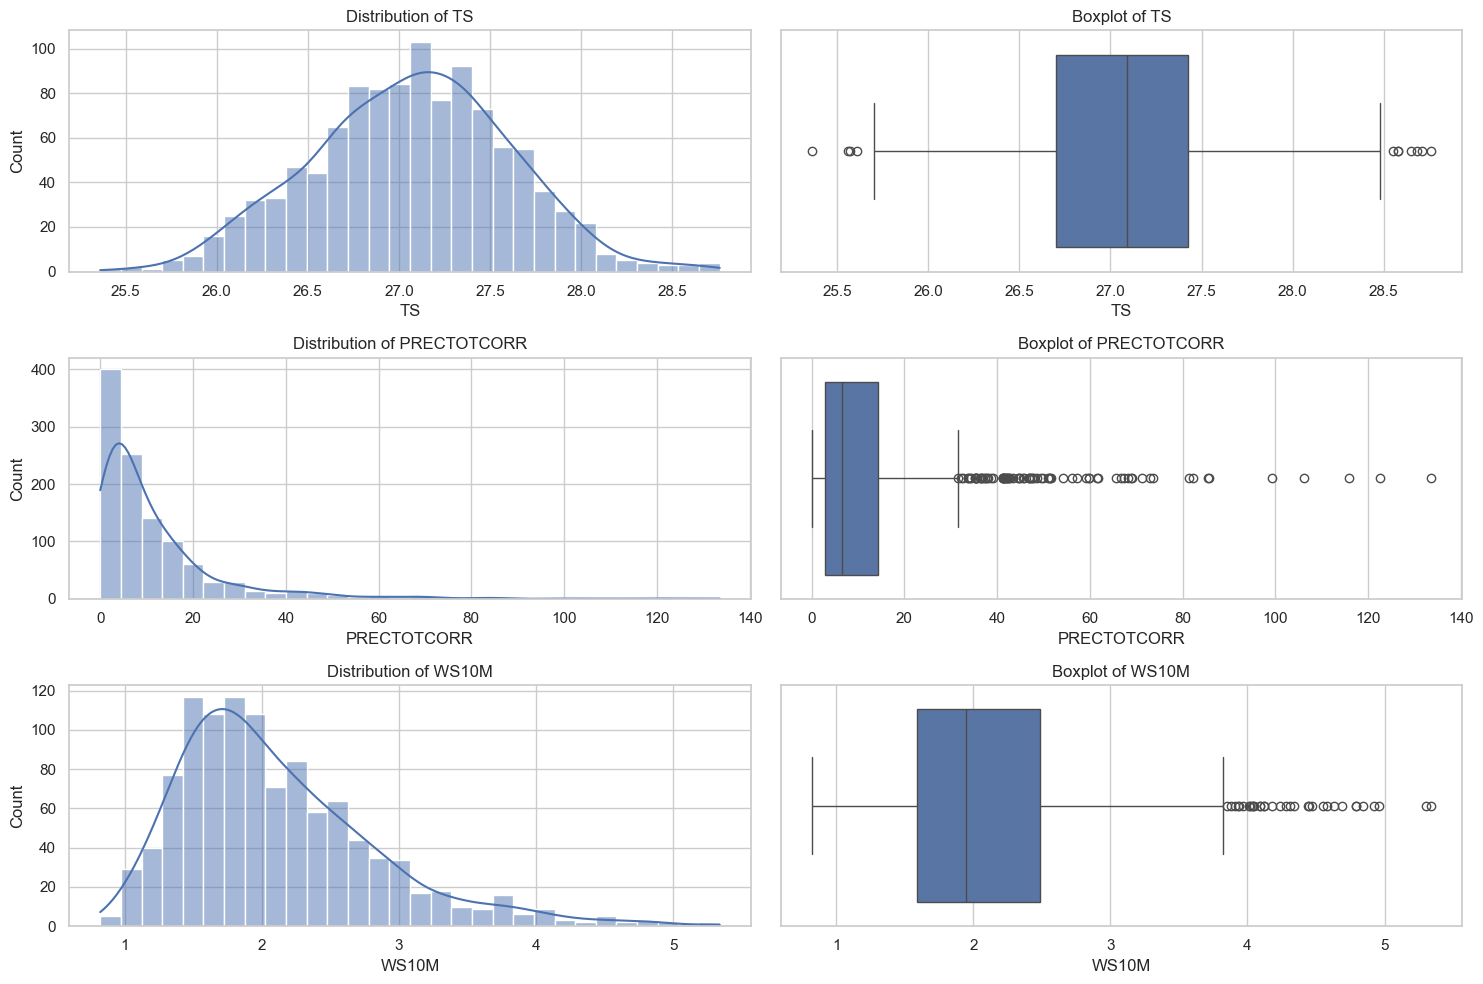

In [11]:
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure for the histograms and box plots
plt.figure(figsize=(15, 10))

# Histogram and Boxplot for TS
plt.subplot(3, 2, 1)
sns.histplot(data['TS'], bins=30, kde=True)
plt.title('Distribution of TS')

plt.subplot(3, 2, 2)
sns.boxplot(x=data['TS'])
plt.title('Boxplot of TS')

# Histogram and Boxplot for PRECTOTCORR
plt.subplot(3, 2, 3)
sns.histplot(data['PRECTOTCORR'], bins=30, kde=True)
plt.title('Distribution of PRECTOTCORR')

plt.subplot(3, 2, 4)
sns.boxplot(x=data['PRECTOTCORR'])
plt.title('Boxplot of PRECTOTCORR')

# Histogram and Boxplot for WS10M
plt.subplot(3, 2, 5)
sns.histplot(data['WS10M'], bins=30, kde=True)
plt.title('Distribution of WS10M')

plt.subplot(3, 2, 6)
sns.boxplot(x=data['WS10M'])
plt.title('Boxplot of WS10M')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### K-Means Clustering

In [15]:
data

,CombinedDate,TS,PRECTOTCORR,WS10M
0,2020-01-01,27.64,1.92,1.50
1,2020-02-01,27.86,0.32,1.33
2,2020-03-01,27.85,1.87,0.97
3,2020-04-01,27.93,2.68,1.19
4,2020-05-01,27.81,8.82,1.53
...,...,...,...,...
427,2022-08-12,26.26,17.21,2.16
428,2022-09-12,26.16,14.47,3.63
429,2022-10-12,26.00,21.81,2.90
430,2022-11-12,26.09,44.73,4.34


In [12]:
x_train = data[["TS", "PRECTOTCORR", "WS10M"]].values
x_train

array([[27.64,  1.92,  1.5 ],
       [27.86,  0.32,  1.33],
       [27.85,  1.87,  0.97],
       ...,
       [26.13, 41.57,  2.42],
       [25.8 , 12.  ,  1.53],
       [26.  , 23.47,  3.31]])

#### Mencari Jumlah k Terbaik

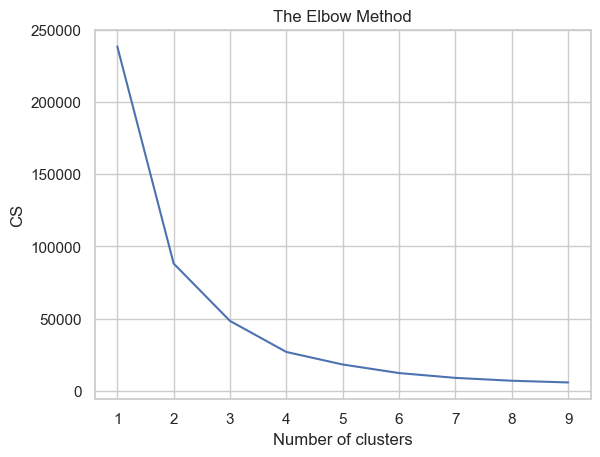

In [13]:
# Elbow method
from sklearn.cluster import KMeans
cs = []
for i in range (1,10):
    kmeans = KMeans(n_clusters=i, init = 'k-means++',max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x_train)
    cs.append(kmeans.inertia_)
plt.plot(range(1,10), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [14]:
# Silhouette method
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=300)
    kmeans.fit(x_train)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(x_train, cluster_labels)
    print("For n_cluster={0}, the silhoutte score is {1}".format(num_clusters, silhouette_avg))

For n_cluster=2, the silhoutte score is 0.7607118913536702
For n_cluster=3, the silhoutte score is 0.6311212919773109
For n_cluster=4, the silhoutte score is 0.624479166910892
For n_cluster=5, the silhoutte score is 0.6176739959723392
For n_cluster=6, the silhoutte score is 0.5266138768310188
For n_cluster=7, the silhoutte score is 0.532095372603806
For n_cluster=8, the silhoutte score is 0.5034722643804711


#### Jumlah k = 2 Terbaik

In [15]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans

KMeans(n_clusters=2, random_state=0)

In [16]:
y_cluster = kmeans.fit_predict(x_train)

In [17]:
data['Cluster'] = y_cluster

In [18]:
kmeans.cluster_centers_

array([[26.81725664, 46.09451327,  2.84088496],
       [27.09802444,  7.56341141,  2.02797352]])

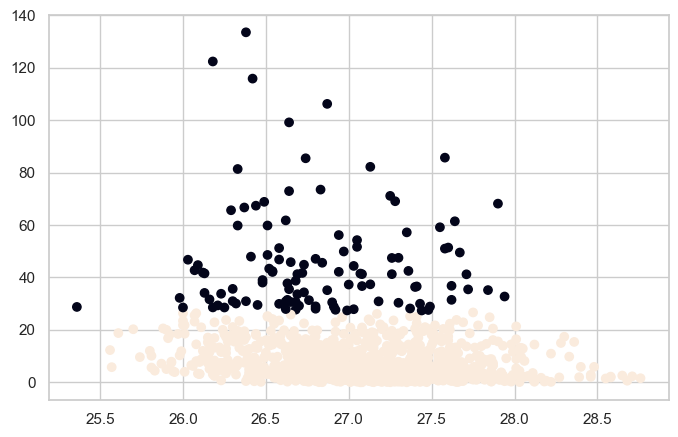

In [19]:
plt.figure(figsize=(8,5))
plt.scatter(x_train[:,0], x_train[:,1], c = kmeans.labels_)

In [20]:
data["Cluster"] = data["Cluster"].astype("object")

data.loc[data.Cluster==0, "Cluster"] = "BERPOTENSI UPWELLING"
data.loc[data.Cluster==1, "Cluster"] = "TIDAK BERPOTENSI UPWELLING"

In [21]:
data.groupby(["Cluster"]).count()

,CombinedDate,TS,PRECTOTCORR,WS10M
Cluster,,,,
BERPOTENSI UPWELLING,44,113,113,113
TIDAK BERPOTENSI UPWELLING,388,982,982,982


In [22]:
# Mengonversi kolom DATE ke format datetime
data['CombinedDate'] = pd.to_datetime(data['CombinedDate'], errors='coerce', dayfirst=True)

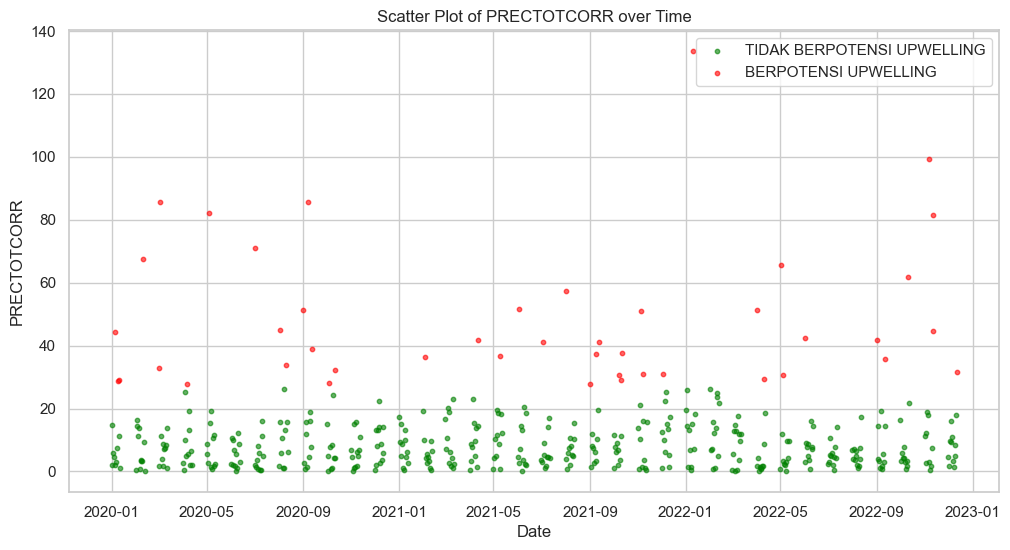

In [23]:
# Menentukan warna berdasarkan cluster
colors = {'BERPOTENSI UPWELLING': 'red', 'TIDAK BERPOTENSI UPWELLING': 'green'}

# Membuat plot
plt.figure(figsize=(12, 6))
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['CombinedDate'], cluster_data['PRECTOTCORR'],
                color=colors[cluster], label=cluster, s=10, alpha=0.6)

# Menambahkan judul dan label
plt.title('Scatter Plot of PRECTOTCORR over Time')
plt.xlabel('Date')
plt.ylabel('PRECTOTCORR')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
data.groupby(["Cluster"]).describe().T

Cluster                     BERPOTENSI UPWELLING  \
Date                  count                  225   
                      mean   2024-10-02 00:57:36   
                      min    2023-06-16 00:00:00   
                      25%    2024-01-26 00:00:00   
                      50%    2024-10-01 00:00:00   
                      75%    2025-05-10 00:00:00   
                      max    2026-01-21 00:00:00   
                      std                    NaN   
TS_Predicted          count                225.0   
                      mean             26.951402   
                      min                  26.31   
                      25%                 26.715   
                      50%              26.907068   
                      75%              27.206664   
                      max              27.796667   
                      std               0.349703   
PRECTOTCORR_Predicted count                225.0   
                      mean             23.671006   
                      min                  15.22   
                      25%              16.865003   
                      50%              20.470005   
                      75%              26.476667   
                      max              62.470004   
                      std               9.552995   
WS10M_Predicted       count                225.0   
                      mean              2.431989   
                      min               1.373333   
                      25%               2.053332   
                      50%               2.402848   
                      75%               2.725003   
                      max               4.020008   
                      std               0.533977   

Cluster                         TIDAK BERPOTENSI UPWELLING  
Date                  count                            743  
                      mean   2024-09-23 12:28:06.137281280  
                      min              2023-05-31 00:00:00  
                      25%              2024-02-02 12:00:00  
                      50%              2024-09-23 00:00:00  
                      75%              2025-05-26 12:00:00  
                      max              2026-01-22 00:00:00  
                      std                              NaN  
TS_Predicted          count                          743.0  
                      mean                       27.130616  
                      min                            26.16  
                      25%                            26.89  
                      50%                        27.145977  
                      75%                        27.386573  
                      max                        27.886667  
                      std                         0.336042  
PRECTOTCORR_Predicted count                          743.0  
                      mean                        6.772867  
                      min                         0.191316  
                      25%                         3.606667  
                      50%                         6.551345  
                      75%                         9.360852  
                      max                        15.029643  
                      std                         3.654989  
WS10M_Predicted       count                          743.0  
                      mean                        2.009748  
                      min                         0.998993  
                      25%                         1.673333  
                      50%                            1.945  
                      75%                         2.260162  
                      max                         3.425001  
                      std                         0.444665

### Visualisasi Data

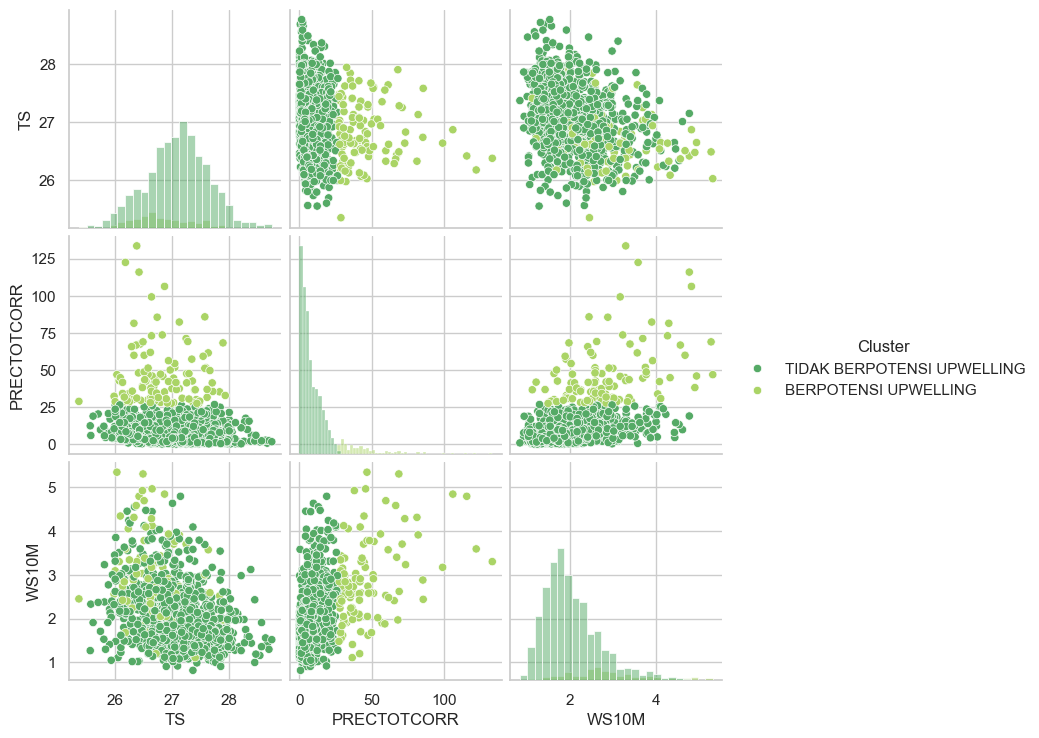

In [24]:
sns.pairplot(data, hue = "Cluster", diag_kind = "hist", palette = "summer")

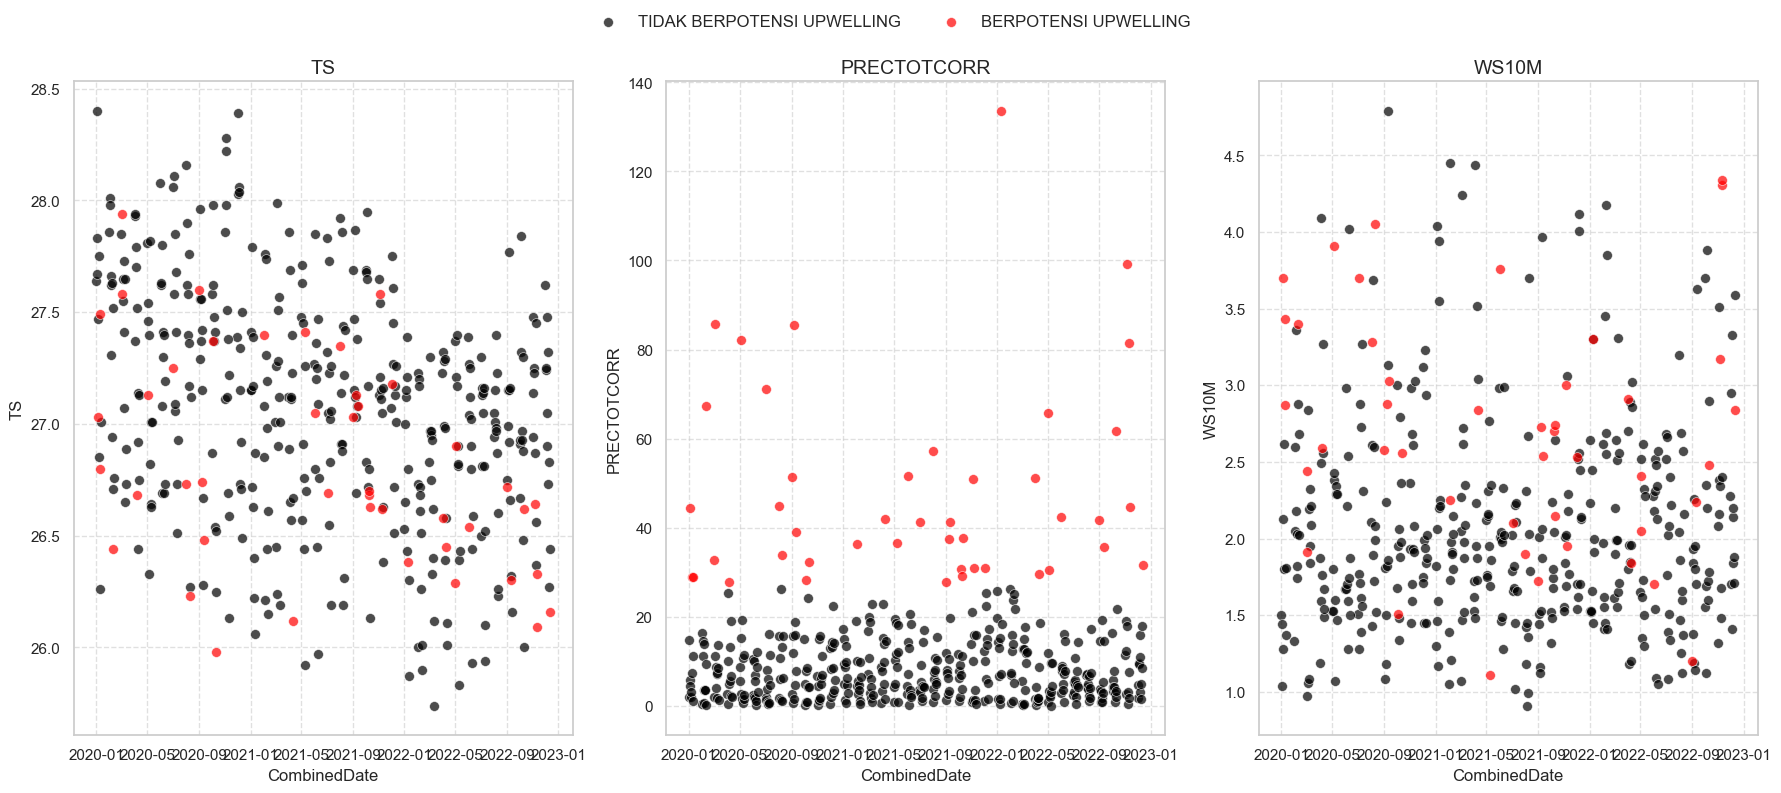

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert DATE to datetime
#data['DATE'] = pd.to_datetime(data['DATE'])

# Menentukan warna berdasarkan cluster
colors = {'BERPOTENSI UPWELLING': 'red', 'TIDAK BERPOTENSI UPWELLING': 'black'}

# Membuat plot
fig, axs = plt.subplots(1, 3, figsize=(18, 8), sharex=True)
variables = ["TS", "PRECTOTCORR", "WS10M"]
titles = ["TS", "PRECTOTCORR", "WS10M"]

for ax, var, title in zip(axs.flatten(), variables, titles):
    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(cluster_data['CombinedDate'], cluster_data[var],
                   color=colors[cluster], label=cluster, s=50, alpha=0.7, edgecolors='w', linewidth=0.5)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('CombinedDate', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Menambahkan satu legenda untuk subplot pertama
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [32]:
#data = data.drop(columns=['CombinedDate'])
data.to_excel('HASIL_FIX.xlsx', index=False)

In [33]:
data.describe

<bound method NDFrame.describe of          TS  PRECTOTCORR  WS10M                     Cluster
0     27.64         1.92   1.50  TIDAK BERPOTENSI UPWELLING
1     27.86         0.32   1.33  TIDAK BERPOTENSI UPWELLING
2     27.85         1.87   0.97  TIDAK BERPOTENSI UPWELLING
3     27.93         2.68   1.19  TIDAK BERPOTENSI UPWELLING
4     27.81         8.82   1.53  TIDAK BERPOTENSI UPWELLING
...     ...          ...    ...                         ...
1090  27.01         3.98   1.62  TIDAK BERPOTENSI UPWELLING
1091  26.79         9.20   1.82  TIDAK BERPOTENSI UPWELLING
1092  26.13        41.57   2.42        BERPOTENSI UPWELLING
1093  25.80        12.00   1.53  TIDAK BERPOTENSI UPWELLING
1094  26.00        23.47   3.31  TIDAK BERPOTENSI UPWELLING

[1095 rows x 4 columns]>

# KLASIFIKASI MODEL

In [34]:
df = pd.read_excel('D:/MODELING_ML/GIT/upwelling-pred-maninjau/data/HASIL_FIX.xlsx')
df.head(10)

,TS,PRECTOTCORR,WS10M,Cluster
0,27.64,1.92,1.50,TIDAK BERPOTENSI UPWELLING
1,27.86,0.32,1.33,TIDAK BERPOTENSI UPWELLING
2,27.85,1.87,0.97,TIDAK BERPOTENSI UPWELLING
3,27.93,2.68,1.19,TIDAK BERPOTENSI UPWELLING
4,27.81,8.82,1.53,TIDAK BERPOTENSI UPWELLING
5,28.08,2.40,1.67,TIDAK BERPOTENSI UPWELLING
6,28.06,2.06,1.51,TIDAK BERPOTENSI UPWELLING
7,28.16,1.73,2.11,TIDAK BERPOTENSI UPWELLING
8,27.60,51.42,2.58,BERPOTENSI UPWELLING
9,26.87,15.06,3.00,TIDAK BERPOTENSI UPWELLING


In [35]:
df.describe()

,TS,PRECTOTCORR,WS10M
count,1095.000000,1095.000000,1095.000000
mean,27.069050,11.539680,2.111863
std,0.543548,14.741376,0.728837
min,25.360000,0.000000,0.820000
25%,26.700000,2.940000,1.590000
50%,27.090000,6.640000,1.950000
75%,27.425000,14.355000,2.490000
max,28.760000,133.560000,5.340000


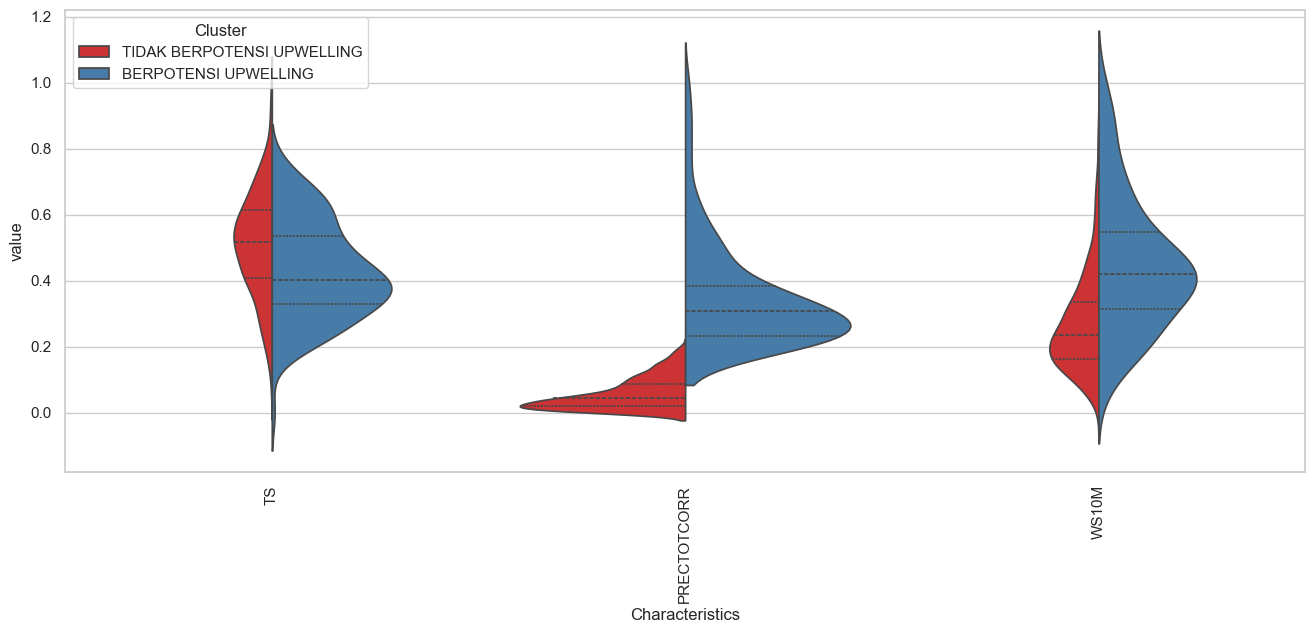

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_scaled = scaler.fit_transform(df_numeric)
df_norm = pd.DataFrame(df_scaled, columns=df_numeric.columns)
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])
df_norm = pd.concat([df_norm, df_non_numeric.reset_index(drop=True)], axis=1)

# violin plot
df_violin = pd.melt(df_norm, "Cluster", var_name="Characteristics")
fig, ax = plt.subplots(figsize=(16,6))
plot_df = sns.violinplot(ax = ax, x="Characteristics", y="value", hue="Cluster", split = True, data=df_violin, inner = 'quartile', palette = 'Set1')
df_selain_class = df.drop(["Cluster"],axis = 1)
plot_df.set_xticklabels(rotation = 90, labels = list(df_selain_class.columns));

In [37]:
# mengubah data object menjadi integer
labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])

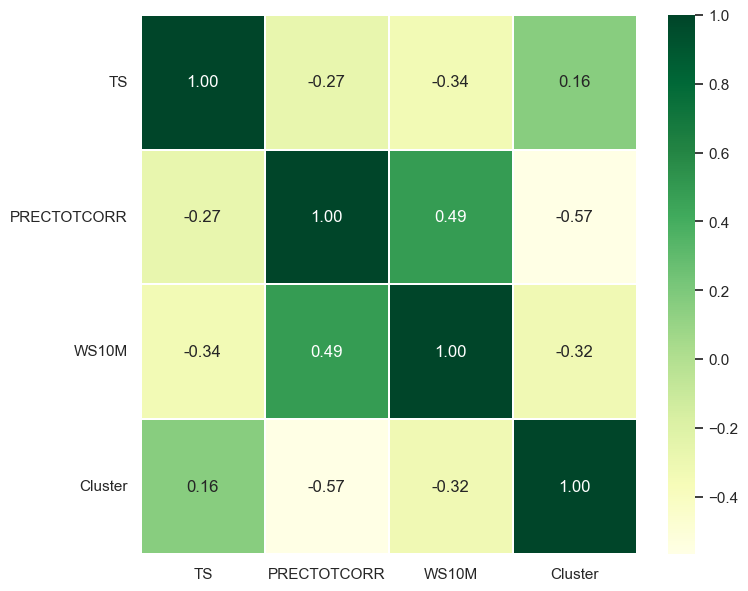

In [38]:
# plot untuk melihat korelasi antar feature
plt.figure(figsize=(8,7))
sns.heatmap(df.corr(),linewidths=.2,cmap="YlGn",fmt=".2f",annot=True, annot_kws={"size": 12})
plt.yticks(rotation=0);

In [39]:
X = df.drop(['Cluster'], axis=1)
y = df["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, stratify=y, random_state=0)

In [40]:
# label untuk teks dibaca sebagai integer
lb = LabelEncoder()
lb.fit(y_train)

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)


In [41]:
X_train.describe()

,TS,PRECTOTCORR,WS10M
count,876.000000,876.000000,876.000000
mean,120.474886,396.038813,107.409817
std,51.217725,245.673188,62.510579
min,0.000000,0.000000,0.000000
25%,83.000000,185.750000,59.000000
50%,123.000000,372.500000,95.000000
75%,155.000000,607.000000,148.000000
max,239.000000,863.000000,274.000000


In [42]:
y_train

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,

In [43]:
y_test

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
      dtype=int64)

In [44]:
X_train.head(19)

,TS,PRECTOTCORR,WS10M
324,118,681,189
45,144,683,242
997,29,716,143
574,136,156,144
713,119,538,88
1008,53,480,132
766,44,846,141
356,136,259,90
1058,26,751,197
291,73,56,64


In [45]:
#KERNEL LINEAR
#MODEL SVM
model = svm.SVC(kernel ='linear')
#train model pake data train
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [46]:
# model svm rbf
model2 = svm.SVC(kernel ='rbf')
#train model pake data train
model2.fit(X_train, y_train)
# predict data set pakai model sudah ditraining
y_pred2 = model2.predict(X_test)
print(y_pred2)

[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [47]:
# model svm polinomial
model3 = svm.SVC(kernel ='poly')
#train model pake data train
model3.fit(X_train, y_train)
# predict data set pakai model sudah ditraining
y_pred3 = model3.predict(X_test)
print(y_pred3)

[1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [48]:
# model linear
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 23   0]
 [  0 196]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       196

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219



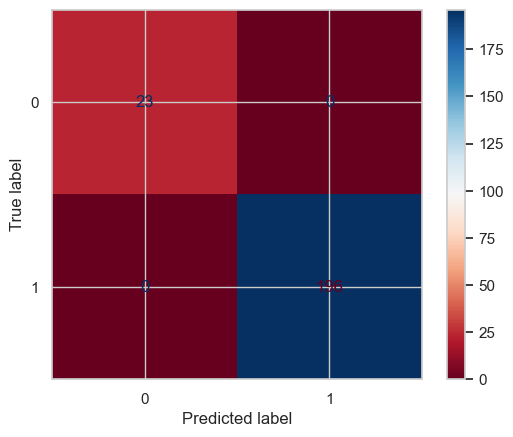

In [49]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=lb.classes_).plot(cmap = "RdBu")

In [50]:
# model rbf
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

[[ 22   1]
 [  0 196]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.99      1.00      1.00       196

    accuracy                           1.00       219
   macro avg       1.00      0.98      0.99       219
weighted avg       1.00      1.00      1.00       219



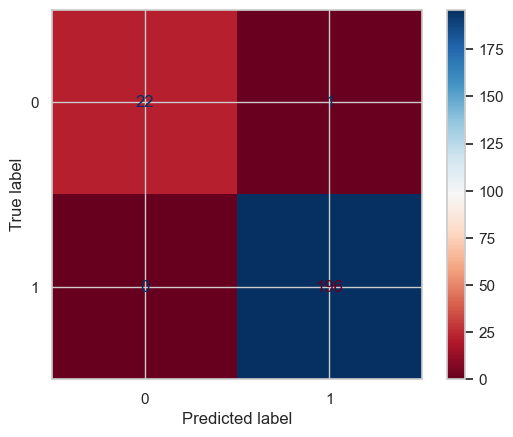

In [51]:
cm = confusion_matrix(y_test, y_pred2)
ConfusionMatrixDisplay(cm, display_labels=lb.classes_).plot(cmap = "RdBu")

In [52]:
# model polinomial
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

[[ 23   0]
 [  0 196]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       196

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219



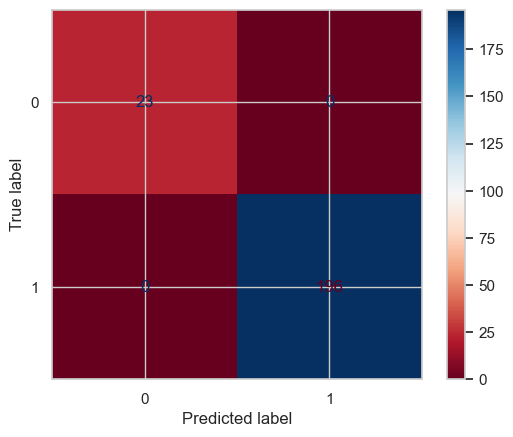

In [53]:
cm = confusion_matrix(y_test, y_pred3)
ConfusionMatrixDisplay(cm, display_labels=lb.classes_).plot(cmap = "RdBu")

In [54]:
from sklearn import svm
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd

# Misalkan X_train, y_train, X_test, dan y_test sudah didefinisikan sebelumnya

classifiers = [
    svm.SVC(kernel='linear'),
    svm.SVC(kernel='rbf'),
    svm.SVC(kernel='poly'),
]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("="*30)
    print(name)

    print('*Results*')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    log_entry = pd.DataFrame([[name, acc*100, 11]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)

    print("="*30)

print(log)


SVC
*Results*
Accuracy: 100.0000%
SVC
*Results*
Accuracy: 99.5434%
SVC
*Results*
Accuracy: 100.0000%
  Classifier    Accuracy Log Loss
0        SVC  100.000000       11
1        SVC   99.543379       11
2        SVC  100.000000       11


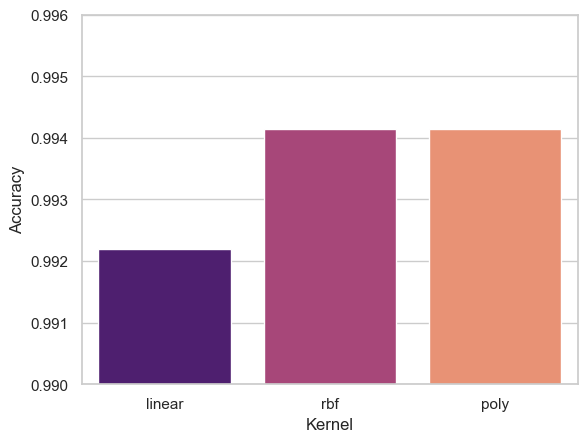

In [55]:
# Data
kernels = ['linear', 'rbf', 'poly']
accuracy = [0.992188, 0.994141, 0.994141]

# Create bar plot
sns.set_style("whitegrid")
sns.barplot(x=kernels, y=accuracy, palette='magma')

# Set labels
plt.xlabel("Kernel")
plt.ylabel("Accuracy")

# Set y-axis scale from 98 to 100
plt.ylim(0.99, 0.996)

# Show plot
plt.show()

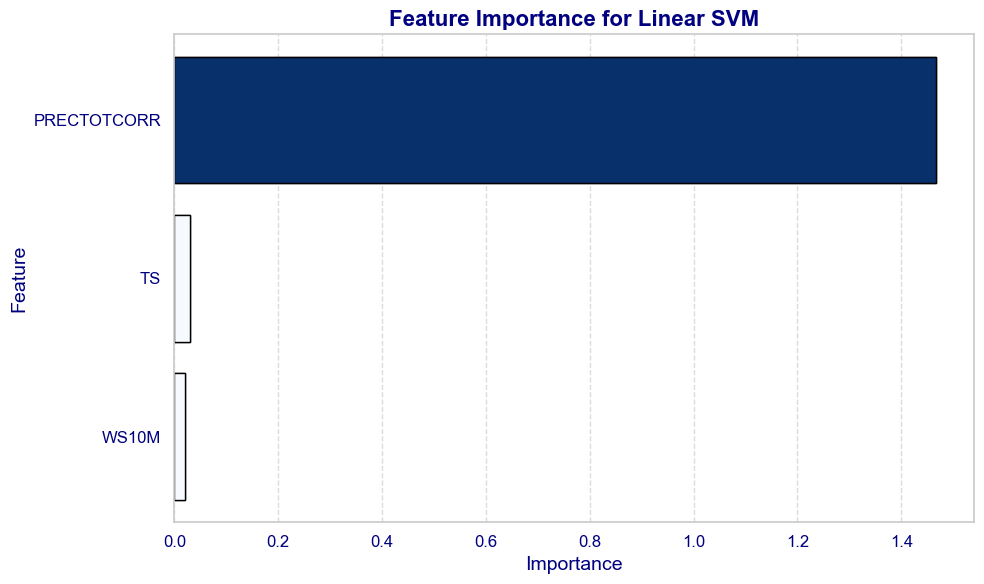

In [57]:
# Ekstraksi koefisien dari model
feature_importance = np.abs(model.coef_[0])
feature_names = X.columns

# Membuat DataFrame untuk visualisasi
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Urutkan berdasarkan kepentingan fitur
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisasi fitur penting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d', edgecolor='black')

# Custom colormap untuk semakin besar semakin pekat warna biru
norm = plt.Normalize(importance_df['Importance'].min(), importance_df['Importance'].max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

# Warna semakin pekat untuk nilai penting yang lebih besar
plt.barh(importance_df['Feature'], importance_df['Importance'], color=plt.cm.Blues(norm(importance_df['Importance'])), edgecolor='black')

plt.title('Feature Importance for Linear SVM', fontsize=16, weight='bold', color='navy')
plt.xlabel('Importance', fontsize=14, color='navy')
plt.ylabel('Feature', fontsize=14, color='navy')
plt.xticks(fontsize=12, color='navy')
plt.yticks(fontsize=12, color='navy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
#plt.colorbar(sm, orientation='vertical')
plt.tight_layout()  # Mengoptimalkan layout untuk tampilan yang lebih baik
plt.show()
